In [99]:
import itertools
import pandas as pd
import statistics

pd.options.mode.chained_assignment = None  # default='warn'
    
def calculateSimilarity(predictionA, predictionB):
    listA = predictionA.split(',')[:-1]
    listB = predictionB.split(',')[:-1]
    distance = 0
    combinations = []
    for a in listA:
        for b in listB:
            if a != b:
                combinations.append(sorted([a, b]))
    pairs = list(set(map(tuple, combinations)))
    for x, y in pairs:
        a = listA.index(x) - listA.index(y)
        b = listB.index(x) - listB.index(y)
        if a * b < 0:
            distance += 1
            
    normalizedDistance = distance / ((12 * (12 - 1)) / 2)
    
    return 100 - (normalizedDistance * 100)

In [100]:
df = pd.read_csv("../2024/leaderboard/data/submissions2024AllColumns.csv")
df = df[['leaderboardAlias', 'prediction']]

In [101]:
## Calculate 'average' drop out position of each candidate
candidateScores = {}
for i in df.index:
    prediction = df['prediction'][i].split(",")[:-1]
    for i, candidate in enumerate(prediction):
        if candidate in candidateScores:
            candidateScores[candidate] += i
        else:
            candidateScores[candidate] = i

averagePredictions = [{'candidate': key, 'value': candidateScores[key] / len(df)} for key in candidateScores.keys()]
averagePredictions.sort(key=lambda x: x['value'])

averageOrder = [ap['candidate'] for ap in averagePredictions]

display(averagePredictions)
print("The 'Wisdom Of The Crowd' predicted drop out order is:")
display(averageOrder)

# Add average answer to submissions
predictionStr = ''
for p in averageOrder:
    predictionStr += p + ','
aggregateRow = {'leaderboardAlias':['Wisdom of the crowd'], 'prediction':[predictionStr]}
aggregateRow = pd.DataFrame(aggregateRow)
df = df.append(aggregateRow, ignore_index=True)

[{'candidate': 'hurd', 'value': 2.08974358974359},
 {'candidate': 'elder', 'value': 2.2564102564102564},
 {'candidate': 'suarez', 'value': 2.730769230769231},
 {'candidate': 'burgum', 'value': 3.3461538461538463},
 {'candidate': 'hutchinson', 'value': 3.3846153846153846},
 {'candidate': 'scott', 'value': 5.987179487179487},
 {'candidate': 'christie', 'value': 6.256410256410256},
 {'candidate': 'ramaswamy', 'value': 6.551282051282051},
 {'candidate': 'haley', 'value': 6.576923076923077},
 {'candidate': 'pence', 'value': 7.141025641025641},
 {'candidate': 'desantis', 'value': 9.076923076923077},
 {'candidate': 'trump', 'value': 10.602564102564102}]

The 'Wisdom Of The Crowd' predicted drop out order is:


['hurd',
 'elder',
 'suarez',
 'burgum',
 'hutchinson',
 'scott',
 'christie',
 'ramaswamy',
 'haley',
 'pence',
 'desantis',
 'trump']

In [103]:
player1 = []
player2 = []
similarity = []

for i1 in df.index:
    # for loop starts with num to avoid finding intersections for characters we've already covered 
    for i2 in df.index:
        if i1 != i2:
            player1.append(df['leaderboardAlias'][i1])
            player2.append(df['leaderboardAlias'][i2])
            similarity.append(calculateSimilarity(df['prediction'][i1], df['prediction'][i2]))
            
assert(len(player1) == len(player2) == len(similarity))

pairs = pd.DataFrame({'player1':player1,'player2':player2,'similarity':similarity})

display(pairs.head(1))

,player1,player2,similarity
0,Amelia Mac,Katie R,63.636364


In [104]:
# convert into proper matrix
matrix = pairs.pivot_table(columns='player2', index='player1', values='similarity').reset_index()
matrix = matrix.fillna(100)

# check network shape
print(matrix.shape)

# save player name column, then drop it from matrix since it's non-numeric and can't go into TSN-E algorithm
player_coordinates = matrix[['player1']]
matrix = matrix.drop(['player1'], axis=1)

(79, 80)


player2,player1,x,y
0,A P,-0.101685,6.451231


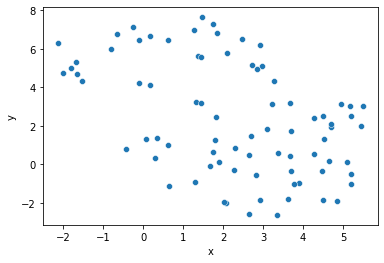

In [105]:
# TSNE stuff
from sklearn.manifold import TSNE
m = TSNE(learning_rate=50)

tsne_features = m.fit_transform(matrix)

# sanity check: each character should have one set of tsne_features values
assert(len(tsne_features) == len(matrix))

# for each character, apply their (x,y) coordinates
player_coordinates['x'] = tsne_features[:,0]
player_coordinates['y'] = tsne_features[:,1]

# looks like this
display(player_coordinates.head(1))

import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(x="x", y="y", data=player_coordinates)
plt.show()

In [114]:
# save coordinates
player_coordinates.to_csv("../2024/leaderboard/data/tsne.csv", index=False)